 # Description
 
 The goal of this notebook is to continue with the EDA. In order to do so, the 'aircraft' table is merged with flight table.

#### Configuration

In [1]:
from sqlalchemy import create_engine
import psycopg2

import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
username = 'postgres'
password = os.environ.get('Db_PASSWORD')
host = 'localhost'
database = 'postgres'
port = '5432'

#### Prepare function to load tables from database

In [4]:
def load_table_from_db(table_name):
    try:
        url = f"postgresql://{username}:{password}@{host}:{port}/{database}"
        engine = create_engine(url)

        df = pd.read_sql_table(f'{table_name}', engine)
        return df

    except Exception as e:
        print("Error while retrieving data from database:", e)
        return None

#### Reading `flight_df_01.csv` created in the previous notebook

In [5]:
flight_df_01 = pd.read_csv(r'..\data\processed\flight_df_01.csv')
flight_df_01.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019,False,True
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019,False,True
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,1199.0,5,4.0,0.0,10.0,0.0,3.0,2019,False,True
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019,False,True
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,581.0,3,NaN,NaN,NaN,NaN,NaN,2019,False,True


In [6]:
len(flight_df_01['tail_num'].unique())

5416

In [7]:
flight_df_01.shape

(1057391, 30)

Loading `aircraft` table from database

In [8]:
aircraft_df = load_table_from_db('aircraft')
aircraft_df.shape

(7383, 4)

#### Prepare `aircraft` table for merge 

In [9]:
aircraft_df.head()

,id,manufacture_year,tail_num,number_of_seats
0,1,1944,N54514,0.0
1,2,1945,N1651M,0.0
2,3,1953,N100CE,0.0
3,4,1953,N141FL,0.0
4,5,1953,N151FL,0.0


Drop columns `number_of_seats` and `id` as well as `duplicates` from aircraft_df

In [10]:
aircraft_df = aircraft_df.drop(columns = ['number_of_seats','id'])
aircraft_df = aircraft_df.drop_duplicates()
aircraft_df.shape

(7364, 2)

Check whether `tail_num` can have more than one `manufacture year`

In [11]:
aircraft_df_is_duplicated = aircraft_df.duplicated(subset='tail_num')
aircraft_df_duplicated = aircraft_df.loc[aircraft_df_is_duplicated]

In [12]:
aircraft_df_duplicated

,manufacture_year,tail_num
2086,2000,N783CA
5725,2014,N856GT
6746,2017,N877AS


There are three cases where tail_num has more than one manufacture year

In [13]:
duplicated_tail_num = aircraft_df.loc[aircraft_df['tail_num'].isin(['N783CA', 'N856GT', 'N877AS'])]
duplicated_tail_num 

,manufacture_year,tail_num
1734,1999,N783CA
2086,2000,N783CA
2460,2001,N877AS
4917,2011,N856GT
5725,2014,N856GT
6746,2017,N877AS


Keep the most recent (last) manufacture year for all three cases

In [14]:
aircraft_df = aircraft_df.sort_values(by='manufacture_year', ascending=True).drop_duplicates(subset='tail_num',keep ='last')
aircraft_df.shape 

(7361, 2)

Check whether the duplicates within `tail_num` were removed correctly.

In [15]:
duplicated_tail_num = aircraft_df.loc[aircraft_df['tail_num'].isin(['N783CA', 'N856GT', 'N877AS'])]
duplicated_tail_num 

,manufacture_year,tail_num
2086,2000,N783CA
5725,2014,N856GT
6746,2017,N877AS


Check for missing values

In [16]:
(aircraft_df['manufacture_year'].isna()).sum()

0

#### Merge `flight_df_01` with `aircraft_df`, save as `tmp_flight_df_01`

In [17]:
tmp_flight_df_01 = flight_df_01.merge(aircraft_df, on='tail_num', how='inner')

In [18]:
tmp_flight_df_01.duplicated().sum()

0

In [19]:
tmp_flight_df_01.shape

(1045174, 31)

`Manufacture_year` variable has been added successfully to `flight_df_01` using `tail_num` as key. Some records has been lost due to `inner` join, though.

In [20]:
tmp_flight_df_01.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,manufacture_year
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,5,NaN,NaN,NaN,NaN,NaN,2019,False,True,2005
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,5,NaN,NaN,NaN,NaN,NaN,2019,False,True,2016
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,5,4.0,0.0,10.0,0.0,3.0,2019,False,True,1998
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,5,NaN,NaN,NaN,NaN,NaN,2019,False,True,1998
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,3,NaN,NaN,NaN,NaN,NaN,2019,False,True,2001


#### Delays vs. manufacture year

Group delays by `manufacture_year`

In [21]:
delays_by_manufacture_year_df = tmp_flight_df_01[tmp_flight_df_01['is_delayed'] == True].groupby\
('manufacture_year')['is_delayed'].count().reset_index()

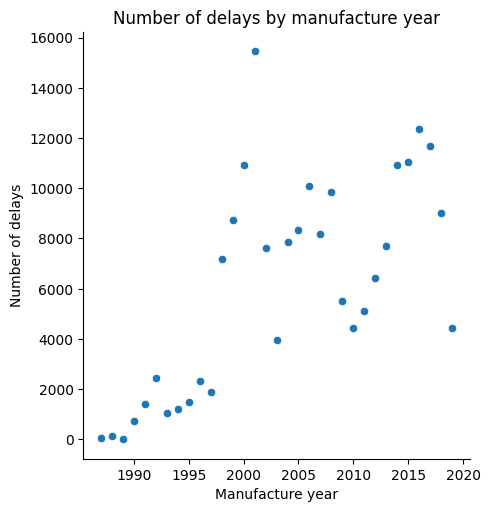

In [22]:
sns.relplot(x='manufacture_year', y='is_delayed', data=delays_by_manufacture_year_df)

plt.title('Number of delays by manufacture year')
plt.xlabel('Manufacture year')
plt.ylabel('Number of delays')

plt.show()

Filter these `manufacture years` which had **more than 10000** flights and create scatter plot again

1. Create a dataframe with number of flights per manufacture year
2. Merge the output with `delays_by_manufacture_year_df`
3. Filter `manufacture_year` so that `total_flights` > 100000

In [23]:
flights_by_manufacture_year = tmp_flight_df_01.groupby('manufacture_year').size().reset_index(name='total_flights')

In [24]:
combined_df = pd.merge(flights_by_manufacture_year, delays_by_manufacture_year_df, on='manufacture_year')

In [25]:
combined_df.head()

,manufacture_year,total_flights,is_delayed
0,1987,443,56
1,1988,634,115
2,1989,13,2
3,1990,4786,744
4,1991,7701,1400


In [26]:
filtered_df = combined_df[combined_df['total_flights'] > 10000]

In [27]:
filtered_df.head()

,manufacture_year,total_flights,is_delayed
5,1992,13882,2444
9,1996,12186,2320
11,1998,40317,7195
12,1999,44018,8732
13,2000,58215,10916


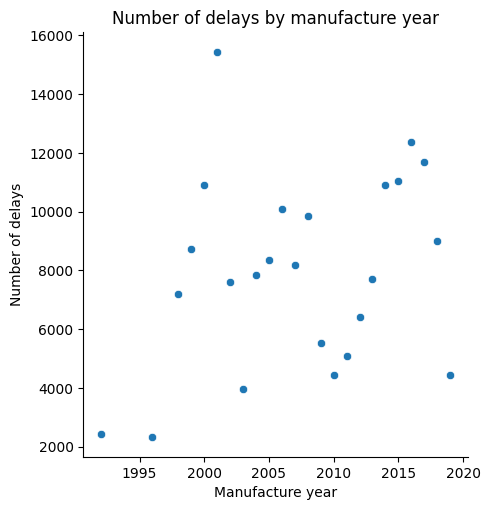

In [28]:
sns.relplot(x='manufacture_year', y='is_delayed', data=filtered_df)

plt.title('Number of delays by manufacture year')
plt.xlabel('Manufacture year')
plt.ylabel('Number of delays')

plt.show()

Aggregate `manufacture_year` into bins with step = 3

In [29]:
bins = range(tmp_flight_df_01['manufacture_year'].min(), tmp_flight_df_01['manufacture_year'].max()+2, 3)

In [30]:
tmp_flight_df_01['manufacture_year_agg'] = pd.cut(tmp_flight_df_01['manufacture_year'], bins, right=False)

Create a bar chart

In [31]:
flight_delays_by_manufacture_year_agg_df = tmp_flight_df_01[tmp_flight_df_01['is_delayed'] == True].groupby\
('manufacture_year_agg')['is_delayed'].size().reset_index(name='delay_count')

C:\Users\sk-se\AppData\Local\Temp\ipykernel_24208\2680099787.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flight_delays_by_manufacture_year_agg_df = tmp_flight_df_01[tmp_flight_df_01['is_delayed'] == True].groupby\


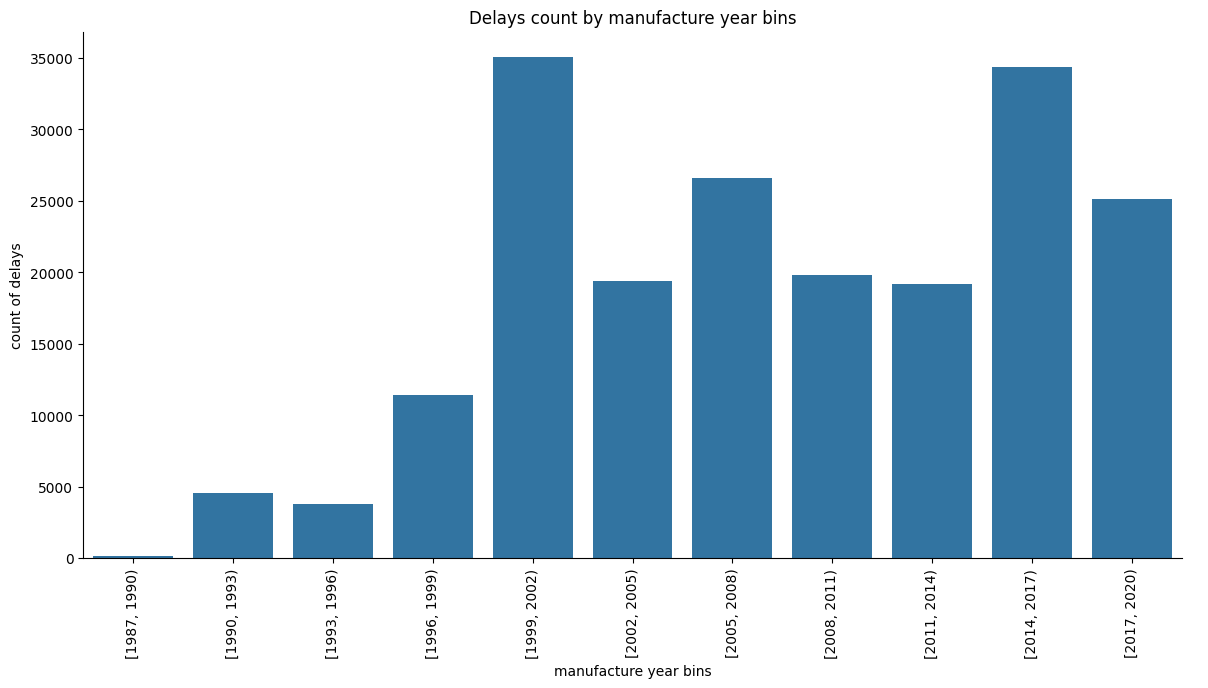

In [32]:
sns.catplot(x='manufacture_year_agg', y='delay_count', data=flight_delays_by_manufacture_year_agg_df,
            kind='bar', height=6, aspect=2)

plt.title('Delays count by manufacture year bins')
plt.xlabel('manufacture year bins')
plt.ylabel('count of delays')

plt.xticks(rotation=90)
plt.show()

#### TOP 5 manufacture years by total number of flights

In [33]:
TOP_5 = combined_df.sort_values(by='total_flights', ascending=False)[0:5]
TOP_5

,manufacture_year,total_flights,is_delayed
14,2001,100251,15450
29,2016,66191,12359
30,2017,62353,11678
27,2014,61128,10921
28,2015,58426,11055


#### TOP 5 manufacture years by delay rate [%] - take into account only `manufacture year` that have `total_flights` > 10K

In [34]:
filtered_df['delay_rate'] = filtered_df['is_delayed'] / filtered_df['total_flights']

C:\Users\sk-se\AppData\Local\Temp\ipykernel_24208\2225153718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delay_rate'] = filtered_df['is_delayed'] / filtered_df['total_flights']


In [35]:
TOP_5_rate = filtered_df.sort_values(by='delay_rate', ascending=True)[0:5]
TOP_5_rate

,manufacture_year,total_flights,is_delayed,delay_rate
14,2001,100251,15450,0.154113
5,1992,13882,2444,0.176055
11,1998,40317,7195,0.178461
27,2014,61128,10921,0.178658
17,2004,43266,7848,0.181390


 # Summary
 
 In this notebook table `aircraft` has been merged into `flight_df_01`, enriching the analysis by another variable - `manufacture_year`.
 
 Insights:
 - Total number of flights differs a lot between various manufacture years. Therefore comparing them in terms of occured delays need to be done with caution. 
 - Top 5 manufacture years (with total flighs > 10K) in terms of delay rate are:
   - 2001,
   - 1992,
   - 1998,
   - 2014,
   - 2004
   
2001 is especially interesting as it has the highest number of total flights and the lowest delay rate (15,4%) at the same time.
 
 

In [36]:
#tmp_flight_df_01.to_csv(r'..\data\processed\flight_df_02.csv',index=False)